# Simple feature-selection example using Lasso and a subset of features

In [83]:
%matplotlib inline

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sklearn.linear_model
import pprint
from IPython.display import display, HTML

## Load Data

In [85]:
train_file = "../data/train.csv"
train_full = pd.read_csv(train_file, index_col=0)

test_file = "../data/test.csv"
test_full = pd.read_csv(test_file, index_col=0)

## Simplify Data

In [86]:
output = "SalePrice"
# Note: GrLivArea = 1stFlrSF+2ndFlrSF+LowQualFinSF
features_simple = ["1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", 
                   "BsmtFinSF1", "BsmtFinSF2", 
                   "BedroomAbvGr",
                   "FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath",
                   ]

# Without .copy(), you're referencing a slice of the original.  Not good!
train = train_full[[output] + features_simple].copy()
test  =  test_full[features_simple].copy()

data = {'train': train,
        'test': test,
       }

## Cleaning data

Find anything that is not a number

In [96]:
ind = {}
for k, d in sorted(data.items()):
    ind[k] = pd.isnull(d[features_simple]).any(1).nonzero()[0]
    print("{}: {}".format(k, ind[k]))
    display(d.iloc[ind[k]])

test: [660 728]


,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
2121,896,0,0,896,NaN,NaN,2,1,0,NaN,NaN
2189,3820,0,0,3820,0.0,0.0,5,3,1,NaN,NaN


train: []


,SalePrice,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,,


Possible ways to fix this:

* Replace missing values with mean of that field
* Predict value of NaN's based on other features (BsmtFinSF based on 1stFlrSF?  Bsmt*Bath based on SF or BasementSF?

For now (and since there's so few missing values), I'll use the simple approach (using mean).  Might be more appropriate to do median at least for the Bathrooms, but...

In [97]:
# for k, d in sorted(data.items()):
for k, d in [('test', data['test'])]:
    print("For {}".format(k))
    print(ind[k])
    for i in ind[k]:
        print("\ti={}".format(i))
#         pd.isnull(d.iloc[i])
        # Print the row
#         print(pd.isnull(d.iloc[i]))
        # Loop through the columns that have nulls
        for c in d.columns[pd.isnull(d.iloc[i])]:
            # Set these values to the mean of this column (excluding any NAN, as .mean does that by default)
            m = d.loc[:,c].mean()
            print("\t\tReplacing {} with mean ({})".format(c, m))
            d.set_value(d.iloc[[i]].index, c, m)
#         print(d.columns[pd.isnull(d.iloc[i])])
#         for x in pd.isnull(d.iloc[i]):
#             print(x)

For test
[660 728]
	i=660
		Replacing BsmtFinSF1 with mean (439.2037037037037)
		Replacing BsmtFinSF2 with mean (52.61934156378601)
		Replacing BsmtFullBath with mean (0.4344543582704187)
		Replacing BsmtHalfBath with mean (0.06520247083047358)
	i=728
		Replacing BsmtFullBath with mean (0.4344543582704187)
		Replacing BsmtHalfBath with mean (0.06520247083047358)


Show everything again...

In [98]:
for k, d in sorted(data.items()):
    display(d.iloc[ind[k]])

,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,
2121,896,0,0,896,439.203704,52.619342,2,1,0,0.434454,0.065202
2189,3820,0,0,3820,0.000000,0.000000,5,3,1,0.434454,0.065202


,SalePrice,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFinSF1,BsmtFinSF2,BedroomAbvGr,FullBath,HalfBath,BsmtFullBath,BsmtHalfBath
Id,,,,,,,,,,,,


And we're in business!

## Inspect the features

Plotting feature 1stFlrSF


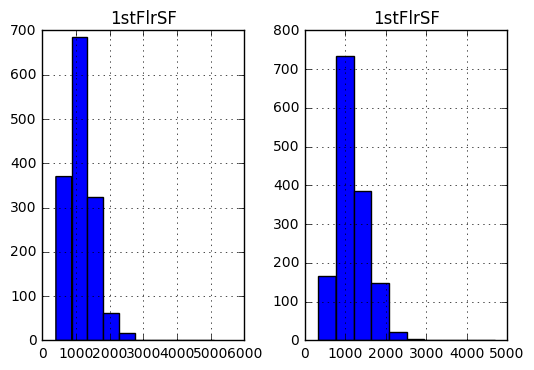

Plotting feature 2ndFlrSF


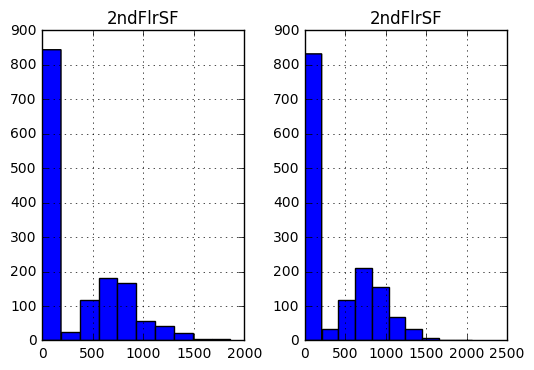

Plotting feature LowQualFinSF


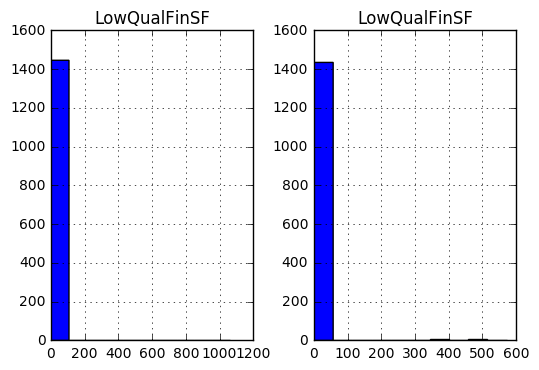

Plotting feature GrLivArea


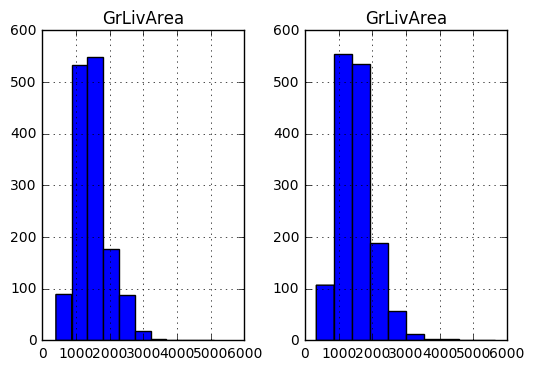

Plotting feature BsmtFinSF1


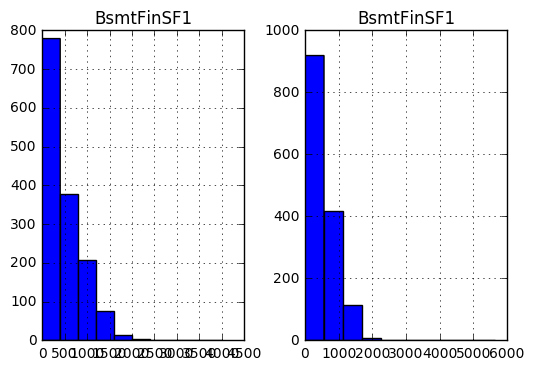

Plotting feature BsmtFinSF2


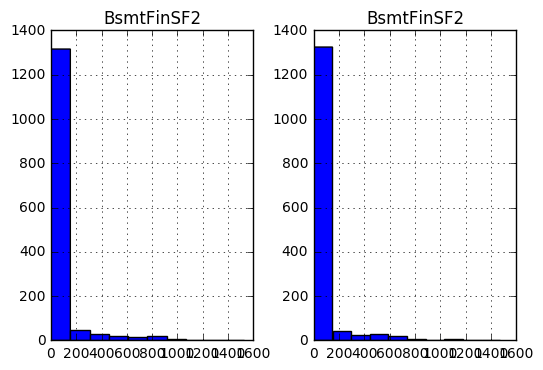

Plotting feature BedroomAbvGr


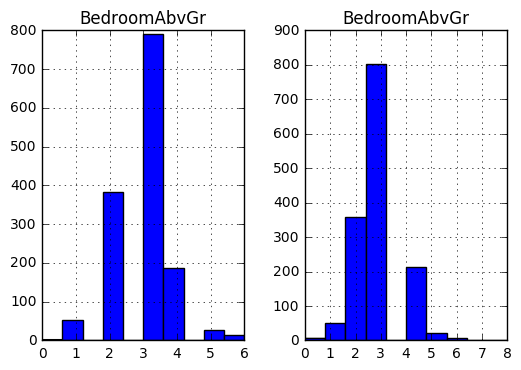

Plotting feature FullBath


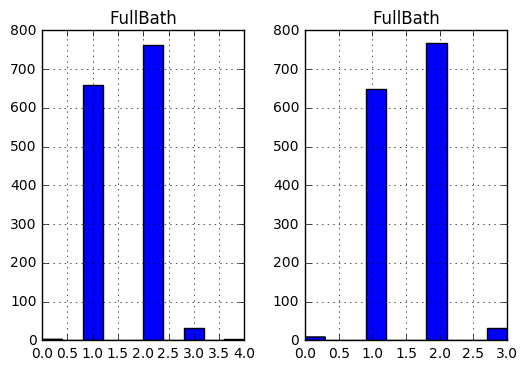

Plotting feature HalfBath


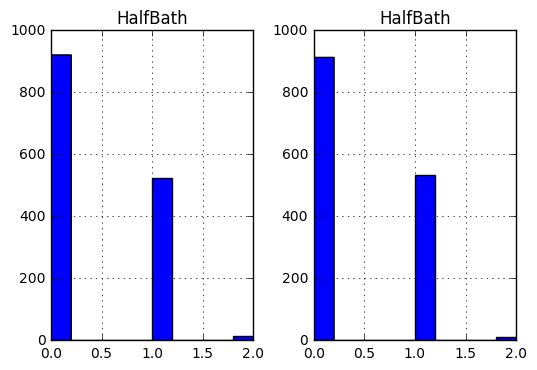

Plotting feature BsmtFullBath


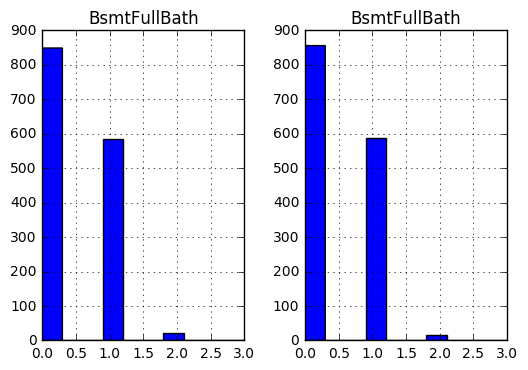

Plotting feature BsmtHalfBath


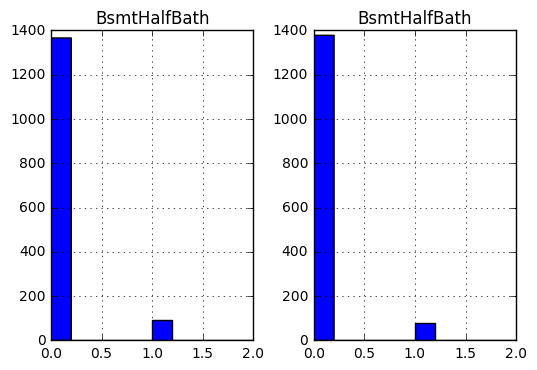

In [107]:
for feat in features_simple:
    print("Plotting feature {}".format(feat))
    fig = plt.figure()
    for i, k in enumerate(sorted(data.keys())):
        ax = fig.add_subplot(1, len(data), i+1)
        data[k].hist(column=feat, ax=ax)
    plt.show()

For now, I won't actually do anything.  Could maybe filter out outliers in the training data.  Could also use this to help determine what sort of features I might engineer (ie sqrt or ^2, etc)

## Use LassoCV to select features

First try to just apply it as is and pick features based on RMS

In [108]:
estimator = sklearn.linear_model.LassoCV(normalize=True, verbose=True)

In [109]:
estimator.fit(data['train'][features_simple], data['train']['SalePrice'])

............................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=True, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=True)

In [114]:
estimator.alpha_

3.1730520172863002

Now try to apply it to pick one feature at a time, then a second feature, then a third...